In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
from numpy.random import choice
import pandas as pd

from glob import glob
from os import listdir, makedirs
from os.path import join

from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, OneOf, RGBShift
from albumentations import ShiftScaleRotate, CenterCrop, Rotate, GaussNoise, Blur, RandomGamma

            
from albumentations.pytorch import ToTensor
from torchvision import models

# Constants

In [3]:
# constants
TRAIN_IMAGES_PATH = '../data/raw/train'
VAL_IMAGES_PATH = '../data/raw/val'
DATASET_PATH = '../data/dataset'

LABELS = ['cleaned', 'dirty']
VAL_PROB = 0.3
SEED = 97

BATCH_SIZE = 8

In [4]:
np.random.seed(SEED)

# Utils

In [5]:
def show_row_dataset(data_path, labels):
    for label in labels:
        print(f'label: {label}')
        folder_path = join(data_path, label)
        imags_paths = glob(join(folder_path, '*.*'))
        num_images = len(imags_paths)
        plt.figure(figsize=(10, 10))
        for i, image_path in enumerate(imags_paths):
            plt.subplot(num_images/4, 4, i+1)
            image = Image.open(image_path)
            plt.imshow(image)
            plt.title(label)
            plt.xticks([])
            plt.yticks([])
        plt.show()

In [6]:
def show_batch(X_batch, y_batch, batch_size):
    plt.figure(figsize=(10, 5))
    for i, (image_tensor, label) in enumerate(zip(X_batch, y_batch)):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image_tensor.permute(1, 2, 0).numpy()
        image = std * image + mean
        plt.subplot(batch_size/4, 4, i+1)
        plt.imshow(image)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])      
    plt.show()

In [7]:
def label_name_to_class(label):
    label_name_to_class_mapping = {'cleaned': 0, 'dirty': 1}
    return label_name_to_class_mapping[label]

def class_to_label_name(cls):
    class_to_label_name_mapping = {'0': 'cleaned', '1': 'dirty'}
    return class_to_label_name_mapping[cls]

In [8]:
def is_val_image(val_prob):
    """With a given probability will return the True or False."""
    
    return choice([True, False], 
                   p=np.array([val_prob, 1 - val_prob])) 

In [9]:
def split_data(data_path, val_prob):
    columns = ['path', 'label']
    train_df = pd.DataFrame(columns=columns)
    val_df = pd.DataFrame(columns=columns)
    images_paths = Path(data_path).glob('**/*.*')
    for image_path in images_paths:
        label = image_path.parent.name
        if is_val_image(VAL_PROB):
            current_val_index = len(val_df)
            val_df.loc[current_val_index] = [image_path, label]
        else:
            current_train_index = len(train_df)
            train_df.loc[current_train_index] = [image_path, label]
    return train_df, val_df

In [10]:
class AlbumentationsDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        lable_to_int = {'cleaned': 0, 'dirty': 1}
        label = lable_to_int[self.labels[idx]]
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [11]:
def create_dataset(df, transform=None):
    file_paths = df['path'].values
    labels = df['label'].values
    dataset = AlbumentationsDataset(file_paths, labels, transform)
    return dataset

# Show dataset

In [12]:
# show_row_dataset(TRAIN_IMAGES_PATH, LABELS)

## Split_data

In [13]:
train_df, val_df = split_data(TRAIN_IMAGES_PATH, VAL_PROB)

# save
dataset_name = f'dataset_{VAL_PROB}_{SEED}'
dataset_path = join(DATASET_PATH, dataset_name)
makedirs(dataset_path, exist_ok=True)

val_df.to_csv(join(dataset_path, 'val.csv'))
train_df.to_csv(join(dataset_path, 'train.csv'))

## Creating dataset

In [14]:
train_transform = Compose([ 
    OneOf([
            ShiftScaleRotate(p=0.25),
            CenterCrop(224, 224, p=0.25),
            Rotate(p=0.25),
            RandomCrop(224, 224, p=0.25),
        ], p=0.9),
    OneOf([
            RGBShift(p=0.25),
            Blur(p=0.25),
            GaussNoise(p=0.25),
            RandomGamma(p=0.25),
        ], p=1),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),
    Resize(224, 224),
    ToTensor()
])

val_transform = Compose([
    Resize(224, 224), 
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),
    ToTensor()
])

In [15]:
dataset_name = f'dataset_{VAL_PROB}_{SEED}'
dataset_path = join(DATASET_PATH, dataset_name)

val_df = pd.read_csv(join(dataset_path, 'val.csv'))
train_df = pd.read_csv(join(dataset_path, 'train.csv'))

train_dataset = create_dataset(train_df, train_transform)
val_dataset = create_dataset(val_df, val_transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1
)

Batch 1


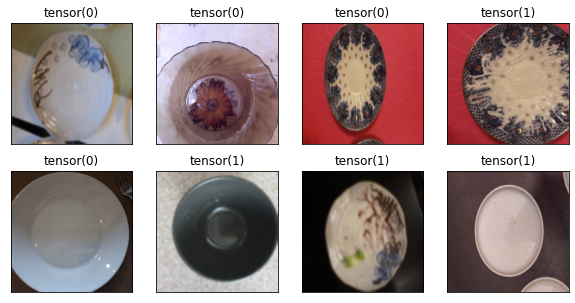

Batch 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


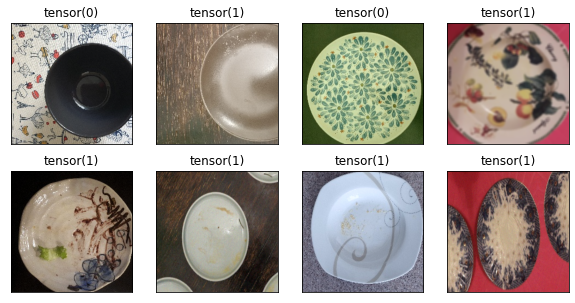

Batch 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


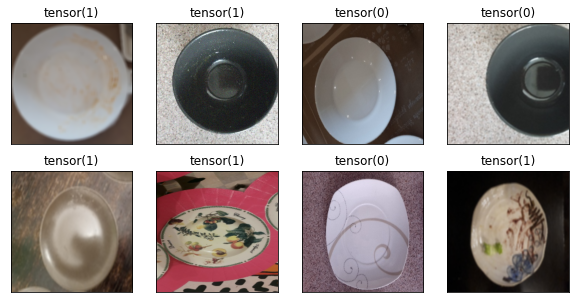

Batch 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


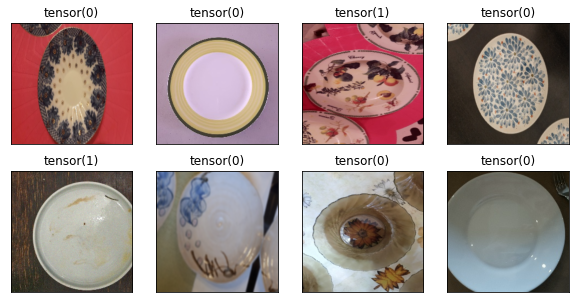

In [16]:
for i in range(4):
    print('Batch', i+1)
    X_batch, y_batch = next(iter(train_dataloader))
    show_batch(X_batch, y_batch, BATCH_SIZE)

# Train

In [17]:
def train_model(model,
                loss,
                optimizer,
                scheduler,
                num_epochs,
                verbose = False):
    
    # Будем записывать промежуточные результаты
    # для дальнейшей визуализации обучения
    train_accuracy_history = []
    train_loss_history = []
    val_accuracy_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        if verbose == True:
            print()
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        # На каждой эпохе будем сначала обучать сеть
        # затем проверять ее качество на валидационной выборке
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
        
            running_loss = 0
            running_acc = 0
            
            # Загружаем данные и
            # и обнуляем градиент
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # На фазе обучения делаем вычисляем ошибку 
                # на тестовой выборке и делаем градиентный шаг
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                running_loss += loss_value.data.cpu()
                running_acc += (preds_class == labels.data).float().mean().data.cpu()
            
            # Средня ошибка и точность на эпохе
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
        
            # Запоминаем значения ошибки и точности 
            # для дальнейшей визуализации
            if phase == 'train':
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            
            if verbose == True:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
    return train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history

In [18]:

model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
history = train_model(model,
                      loss,
                      optimizer,
                      scheduler,
                      num_epochs=1000,
                      verbose = True);


Epoch 0/999:


/home/aynes/Desktop/WorkSpace/dirty_plate_classifier/venv/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.9240 Acc: 0.4167
val Loss: 0.8293 Acc: 0.5000

Epoch 1/999:
train Loss: 0.8051 Acc: 0.2917
val Loss: 0.7213 Acc: 0.5000

Epoch 2/999:
train Loss: 0.7017 Acc: 0.6250
val Loss: 0.8234 Acc: 0.3750

Epoch 3/999:
train Loss: 0.6201 Acc: 0.5833
val Loss: 0.7755 Acc: 0.3750

Epoch 4/999:
train Loss: 0.6031 Acc: 0.7083
val Loss: 0.6896 Acc: 0.4375

Epoch 5/999:
train Loss: 0.6085 Acc: 0.6667
val Loss: 0.6115 Acc: 0.7500

Epoch 6/999:
train Loss: 0.5221 Acc: 0.8750
val Loss: 0.6114 Acc: 0.7500

Epoch 7/999:
train Loss: 0.5453 Acc: 0.7500
val Loss: 0.6245 Acc: 0.7500

Epoch 8/999:
train Loss: 0.4939 Acc: 0.7917
val Loss: 0.6278 Acc: 0.6875

Epoch 9/999:
train Loss: 0.4903 Acc: 0.8333
val Loss: 0.6287 Acc: 0.6875

Epoch 10/999:
train Loss: 0.5334 Acc: 0.7917
val Loss: 0.6348 Acc: 0.6875

Epoch 11/999:
train Loss: 0.4882 Acc: 0.7917
val Loss: 0.6421 Acc: 0.6875

Epoch 12/999:
train Loss: 0.4766 Acc: 0.8333
val Loss: 0.6470 Acc: 0.6875

Epoch 13/999:
train Loss: 0.5482 Acc: 0.6250
val

val Loss: 0.6572 Acc: 0.6875

Epoch 110/999:
train Loss: 0.5161 Acc: 0.7917
val Loss: 0.6513 Acc: 0.6875

Epoch 111/999:
train Loss: 0.5108 Acc: 0.7083
val Loss: 0.6439 Acc: 0.6875

Epoch 112/999:
train Loss: 0.4865 Acc: 0.8750
val Loss: 0.6396 Acc: 0.6875

Epoch 113/999:
train Loss: 0.5361 Acc: 0.7917
val Loss: 0.6421 Acc: 0.6875

Epoch 114/999:
train Loss: 0.4929 Acc: 0.7917
val Loss: 0.6384 Acc: 0.6875

Epoch 115/999:
train Loss: 0.4516 Acc: 0.8333
val Loss: 0.6410 Acc: 0.6875

Epoch 116/999:
train Loss: 0.5256 Acc: 0.7917
val Loss: 0.6397 Acc: 0.6875

Epoch 117/999:
train Loss: 0.4724 Acc: 0.7500
val Loss: 0.6329 Acc: 0.6875

Epoch 118/999:
train Loss: 0.5266 Acc: 0.7917
val Loss: 0.6368 Acc: 0.6875

Epoch 119/999:
train Loss: 0.4835 Acc: 0.7917
val Loss: 0.6411 Acc: 0.6875

Epoch 120/999:
train Loss: 0.5606 Acc: 0.6667
val Loss: 0.6522 Acc: 0.6875

Epoch 121/999:
train Loss: 0.4652 Acc: 0.8750
val Loss: 0.6383 Acc: 0.6875

Epoch 122/999:
train Loss: 0.4754 Acc: 0.8750
val Loss: 0.

val Loss: 0.6570 Acc: 0.6875

Epoch 218/999:
train Loss: 0.5030 Acc: 0.7500
val Loss: 0.6487 Acc: 0.6875

Epoch 219/999:
train Loss: 0.4696 Acc: 0.8750
val Loss: 0.6505 Acc: 0.6875

Epoch 220/999:
train Loss: 0.5278 Acc: 0.7500
val Loss: 0.6404 Acc: 0.6875

Epoch 221/999:
train Loss: 0.5147 Acc: 0.7917
val Loss: 0.6450 Acc: 0.6875

Epoch 222/999:
train Loss: 0.5536 Acc: 0.7083
val Loss: 0.6353 Acc: 0.6875

Epoch 223/999:
train Loss: 0.4788 Acc: 0.8333
val Loss: 0.6309 Acc: 0.6875

Epoch 224/999:
train Loss: 0.5289 Acc: 0.8333
val Loss: 0.6371 Acc: 0.6875

Epoch 225/999:
train Loss: 0.4991 Acc: 0.7917
val Loss: 0.6354 Acc: 0.6875

Epoch 226/999:
train Loss: 0.5720 Acc: 0.6667
val Loss: 0.6430 Acc: 0.6875

Epoch 227/999:
train Loss: 0.5250 Acc: 0.8333
val Loss: 0.6398 Acc: 0.6875

Epoch 228/999:
train Loss: 0.4416 Acc: 0.9167
val Loss: 0.6505 Acc: 0.6875

Epoch 229/999:
train Loss: 0.4802 Acc: 0.8750
val Loss: 0.6501 Acc: 0.6875

Epoch 230/999:
train Loss: 0.4836 Acc: 0.9167
val Loss: 0.

val Loss: 0.6527 Acc: 0.6875

Epoch 326/999:
train Loss: 0.4464 Acc: 0.8750
val Loss: 0.6527 Acc: 0.6875

Epoch 327/999:
train Loss: 0.4896 Acc: 0.8750
val Loss: 0.6523 Acc: 0.6875

Epoch 328/999:
train Loss: 0.4448 Acc: 0.8333
val Loss: 0.6542 Acc: 0.6875

Epoch 329/999:
train Loss: 0.4548 Acc: 0.9583
val Loss: 0.6469 Acc: 0.6875

Epoch 330/999:
train Loss: 0.4439 Acc: 0.8333
val Loss: 0.6421 Acc: 0.6875

Epoch 331/999:
train Loss: 0.5319 Acc: 0.7500
val Loss: 0.6404 Acc: 0.6875

Epoch 332/999:
train Loss: 0.5317 Acc: 0.7500
val Loss: 0.6560 Acc: 0.6875

Epoch 333/999:
train Loss: 0.4900 Acc: 0.7917
val Loss: 0.6369 Acc: 0.6875

Epoch 334/999:
train Loss: 0.5192 Acc: 0.7500
val Loss: 0.6437 Acc: 0.6875

Epoch 335/999:
train Loss: 0.5193 Acc: 0.7500
val Loss: 0.6467 Acc: 0.6875

Epoch 336/999:
train Loss: 0.4702 Acc: 0.9167
val Loss: 0.6543 Acc: 0.6875

Epoch 337/999:
train Loss: 0.4887 Acc: 0.8333
val Loss: 0.6478 Acc: 0.6875

Epoch 338/999:
train Loss: 0.5227 Acc: 0.7917
val Loss: 0.

val Loss: 0.6448 Acc: 0.6875

Epoch 434/999:
train Loss: 0.4398 Acc: 0.9167
val Loss: 0.6442 Acc: 0.6875

Epoch 435/999:
train Loss: 0.4571 Acc: 0.8333
val Loss: 0.6422 Acc: 0.6875

Epoch 436/999:
train Loss: 0.5659 Acc: 0.7083
val Loss: 0.6473 Acc: 0.6875

Epoch 437/999:
train Loss: 0.5365 Acc: 0.7083
val Loss: 0.6441 Acc: 0.6875

Epoch 438/999:
train Loss: 0.5197 Acc: 0.8333
val Loss: 0.6554 Acc: 0.6875

Epoch 439/999:
train Loss: 0.4717 Acc: 0.8750
val Loss: 0.6548 Acc: 0.6875

Epoch 440/999:
train Loss: 0.5323 Acc: 0.7500
val Loss: 0.6627 Acc: 0.6875

Epoch 441/999:
train Loss: 0.4509 Acc: 0.8750
val Loss: 0.6503 Acc: 0.6875

Epoch 442/999:
train Loss: 0.5407 Acc: 0.7917
val Loss: 0.6457 Acc: 0.6875

Epoch 443/999:
train Loss: 0.4789 Acc: 0.8333
val Loss: 0.6497 Acc: 0.6875

Epoch 444/999:
train Loss: 0.4423 Acc: 0.8750
val Loss: 0.6517 Acc: 0.6875

Epoch 445/999:
train Loss: 0.4558 Acc: 0.9167
val Loss: 0.6504 Acc: 0.6875

Epoch 446/999:
train Loss: 0.5280 Acc: 0.7500
val Loss: 0.

val Loss: 0.6517 Acc: 0.6875

Epoch 542/999:
train Loss: 0.5651 Acc: 0.7917
val Loss: 0.6521 Acc: 0.6875

Epoch 543/999:
train Loss: 0.4905 Acc: 0.8333
val Loss: 0.6469 Acc: 0.6875

Epoch 544/999:
train Loss: 0.4890 Acc: 0.8333
val Loss: 0.6449 Acc: 0.6875

Epoch 545/999:
train Loss: 0.4690 Acc: 0.7500
val Loss: 0.6471 Acc: 0.6875

Epoch 546/999:
train Loss: 0.4963 Acc: 0.8333
val Loss: 0.6530 Acc: 0.6875

Epoch 547/999:
train Loss: 0.4772 Acc: 0.7500
val Loss: 0.6498 Acc: 0.6875

Epoch 548/999:
train Loss: 0.4923 Acc: 0.9167
val Loss: 0.6505 Acc: 0.6875

Epoch 549/999:
train Loss: 0.5011 Acc: 0.7500
val Loss: 0.6558 Acc: 0.6875

Epoch 550/999:
train Loss: 0.4633 Acc: 0.7917
val Loss: 0.6596 Acc: 0.6875

Epoch 551/999:
train Loss: 0.4504 Acc: 0.8750
val Loss: 0.6467 Acc: 0.6875

Epoch 552/999:
train Loss: 0.5103 Acc: 0.7083
val Loss: 0.6555 Acc: 0.6875

Epoch 553/999:
train Loss: 0.4910 Acc: 0.8333
val Loss: 0.6524 Acc: 0.6875

Epoch 554/999:
train Loss: 0.5413 Acc: 0.7500
val Loss: 0.

val Loss: 0.6747 Acc: 0.6875

Epoch 650/999:
train Loss: 0.4567 Acc: 0.8750
val Loss: 0.6603 Acc: 0.6875

Epoch 651/999:
train Loss: 0.5091 Acc: 0.8750
val Loss: 0.6548 Acc: 0.6875

Epoch 652/999:
train Loss: 0.4971 Acc: 0.8333
val Loss: 0.6543 Acc: 0.6875

Epoch 653/999:
train Loss: 0.5234 Acc: 0.7083
val Loss: 0.6597 Acc: 0.6875

Epoch 654/999:
train Loss: 0.4632 Acc: 0.7917
val Loss: 0.6702 Acc: 0.6875

Epoch 655/999:
train Loss: 0.5003 Acc: 0.8333
val Loss: 0.6634 Acc: 0.6875

Epoch 656/999:
train Loss: 0.5439 Acc: 0.6667
val Loss: 0.6722 Acc: 0.6875

Epoch 657/999:
train Loss: 0.4845 Acc: 0.8333
val Loss: 0.6684 Acc: 0.6875

Epoch 658/999:
train Loss: 0.4213 Acc: 0.9583
val Loss: 0.6661 Acc: 0.6875

Epoch 659/999:
train Loss: 0.5124 Acc: 0.7917
val Loss: 0.6586 Acc: 0.6875

Epoch 660/999:
train Loss: 0.5395 Acc: 0.7500
val Loss: 0.6577 Acc: 0.6875

Epoch 661/999:
train Loss: 0.5538 Acc: 0.7917
val Loss: 0.6450 Acc: 0.6875

Epoch 662/999:
train Loss: 0.4859 Acc: 0.8333
val Loss: 0.

val Loss: 0.6322 Acc: 0.6875

Epoch 758/999:
train Loss: 0.4828 Acc: 0.7500
val Loss: 0.6373 Acc: 0.6875

Epoch 759/999:
train Loss: 0.5234 Acc: 0.8750
val Loss: 0.6381 Acc: 0.6875

Epoch 760/999:
train Loss: 0.4398 Acc: 0.8333
val Loss: 0.6423 Acc: 0.6875

Epoch 761/999:
train Loss: 0.4866 Acc: 0.8333
val Loss: 0.6467 Acc: 0.6875

Epoch 762/999:
train Loss: 0.4901 Acc: 0.7917
val Loss: 0.6558 Acc: 0.6875

Epoch 763/999:
train Loss: 0.4959 Acc: 0.7917
val Loss: 0.6581 Acc: 0.6875

Epoch 764/999:
train Loss: 0.5477 Acc: 0.8333
val Loss: 0.6612 Acc: 0.6875

Epoch 765/999:
train Loss: 0.4934 Acc: 0.8333
val Loss: 0.6586 Acc: 0.6875

Epoch 766/999:
train Loss: 0.5205 Acc: 0.8750
val Loss: 0.6580 Acc: 0.6875

Epoch 767/999:
train Loss: 0.4346 Acc: 0.8750
val Loss: 0.6441 Acc: 0.6875

Epoch 768/999:
train Loss: 0.4833 Acc: 0.7500
val Loss: 0.6444 Acc: 0.6875

Epoch 769/999:
train Loss: 0.5196 Acc: 0.7500
val Loss: 0.6544 Acc: 0.6875

Epoch 770/999:
train Loss: 0.4790 Acc: 0.8333
val Loss: 0.

val Loss: 0.6433 Acc: 0.6875

Epoch 866/999:
train Loss: 0.6228 Acc: 0.5833
val Loss: 0.6415 Acc: 0.6875

Epoch 867/999:
train Loss: 0.5107 Acc: 0.7917
val Loss: 0.6434 Acc: 0.6875

Epoch 868/999:
train Loss: 0.5436 Acc: 0.7917
val Loss: 0.6449 Acc: 0.6875

Epoch 869/999:
train Loss: 0.4940 Acc: 0.7500
val Loss: 0.6488 Acc: 0.6875

Epoch 870/999:
train Loss: 0.4329 Acc: 0.9167
val Loss: 0.6417 Acc: 0.6875

Epoch 871/999:
train Loss: 0.4958 Acc: 0.7917
val Loss: 0.6440 Acc: 0.6875

Epoch 872/999:
train Loss: 0.5399 Acc: 0.7500
val Loss: 0.6416 Acc: 0.6875

Epoch 873/999:
train Loss: 0.4622 Acc: 0.8333
val Loss: 0.6449 Acc: 0.6875

Epoch 874/999:
train Loss: 0.4140 Acc: 0.9167
val Loss: 0.6433 Acc: 0.6875

Epoch 875/999:
train Loss: 0.4456 Acc: 0.8750
val Loss: 0.6483 Acc: 0.6875

Epoch 876/999:
train Loss: 0.5686 Acc: 0.7500
val Loss: 0.6373 Acc: 0.6875

Epoch 877/999:
train Loss: 0.4405 Acc: 0.8750
val Loss: 0.6349 Acc: 0.6875

Epoch 878/999:
train Loss: 0.5622 Acc: 0.7500
val Loss: 0.

val Loss: 0.6293 Acc: 0.6875

Epoch 974/999:
train Loss: 0.5216 Acc: 0.7500
val Loss: 0.6289 Acc: 0.6875

Epoch 975/999:
train Loss: 0.5085 Acc: 0.7500
val Loss: 0.6344 Acc: 0.6875

Epoch 976/999:
train Loss: 0.4791 Acc: 0.9167
val Loss: 0.6308 Acc: 0.6875

Epoch 977/999:
train Loss: 0.5730 Acc: 0.6667
val Loss: 0.6333 Acc: 0.6875

Epoch 978/999:
train Loss: 0.5148 Acc: 0.7917
val Loss: 0.6447 Acc: 0.6875

Epoch 979/999:
train Loss: 0.5353 Acc: 0.7500
val Loss: 0.6408 Acc: 0.6875

Epoch 980/999:
train Loss: 0.4886 Acc: 0.8333
val Loss: 0.6462 Acc: 0.6875

Epoch 981/999:
train Loss: 0.4766 Acc: 0.8333
val Loss: 0.6538 Acc: 0.6875

Epoch 982/999:
train Loss: 0.5057 Acc: 0.8333
val Loss: 0.6546 Acc: 0.6875

Epoch 983/999:
train Loss: 0.4961 Acc: 0.8333
val Loss: 0.6481 Acc: 0.6875

Epoch 984/999:
train Loss: 0.4551 Acc: 0.8750
val Loss: 0.6360 Acc: 0.6875

Epoch 985/999:
train Loss: 0.5101 Acc: 0.7083
val Loss: 0.6443 Acc: 0.6875

Epoch 986/999:
train Loss: 0.5299 Acc: 0.7500
val Loss: 0.

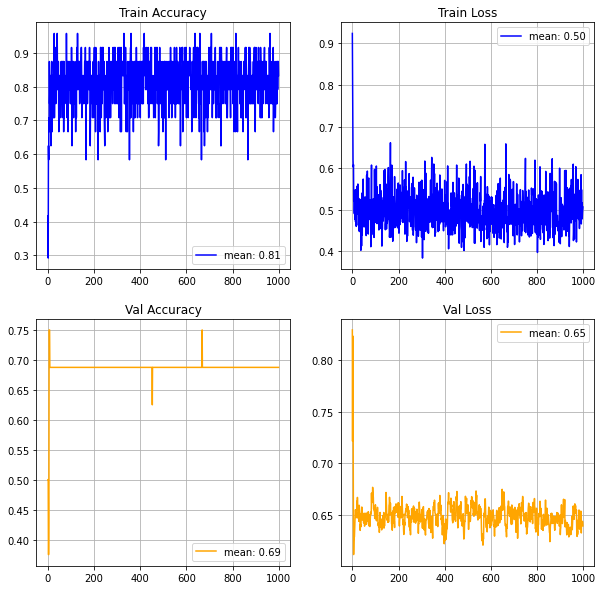

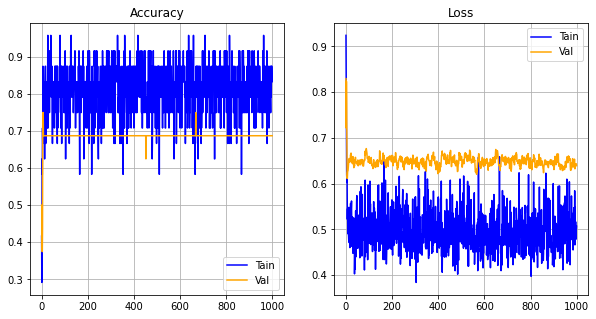

In [20]:
# Рисуем графики  Accuracy и Loss для Тренеровочной и валидационной выборки
titles = ['Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss']
plt.figure(figsize=(10, 10))
for i, image in enumerate(history):
    plt.subplot(2, 2, i+1)
    plt.title(titles[i])
    plt.grid()
    if i == 0 or i == 1:
        color = 'b'
    else:
        color = 'orange'
    plt.plot(image,c=color, label= 'mean: %.2f' % np.array(image).mean())
    plt.legend(loc='best')
plt.show()

# Рисуем совмещенные графики  Accuracy и Loss для Тренеровочной и валидационной выборки
titles_ = ['Accuracy','Loss']
plt.figure(figsize=(10, 5))
k=0
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(history[0+k], label='Tain', c='b')
    plt.plot(history[2+k], label='Val', c='orange')
    plt.title(titles_[i])
    plt.grid()
    plt.legend(loc='best')
    k += 1